In [93]:
import operator
import os
import random
import sys

import dask.array as da
import dask.dataframe as dd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dask.distributed import Client
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_score
from sklearn.tree import export_graphviz

import dask_ml.cluster
import joblib
import lime
import lime.lime_tabular
import pydot
from treeinterpreter import treeinterpreter as ti

In [94]:
client = Client()

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:40016 remote=tcp://127.0.0.1:42863>


In [96]:
df = pd.read_csv('../data/sample_processed.csv')

In [97]:
ddf = dd.from_pandas(df, npartitions=16)

**Clustering**

In [98]:
clustering_on = ['Normalized_Rank', 'Median_score', ]

In [99]:
data = ddf[clustering_on].compute(num_workers=4)

In [100]:
upper_n_clusters = 5
num_workers = 4

In [101]:
num_of_clusters_to_fit = range(2, upper_n_clusters)

In [102]:
silhouette_avgs = {}
for n_clusters in num_of_clusters_to_fit:
    kmeans = dask_ml.cluster.KMeans(n_clusters=n_clusters, random_state=0).fit(data)
    ddf['Clusters: n = %s' % n_clusters] = dd.from_dask_array(kmeans.labels_)
    
    with joblib.parallel_backend('dask', n_jobs=num_workers):
        silhouette_avg = silhouette_score(data, kmeans.labels_, sample_size=int(len(data) * .001))
        silhouette_avgs['Clusters: n = %s' % n_clusters] = silhouette_avg

In [103]:
sample = ddf.sample(frac=0.01)

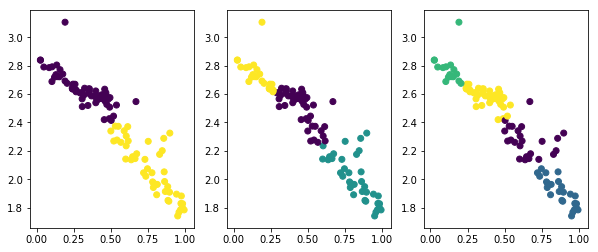

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=upper_n_clusters - 2, figsize=(10, 4))

x = sample['Normalized_Rank'].compute()
y = sample['Median_score'].compute()

for i, ax in enumerate(axes):
    ax.scatter(x, y, c=sample['Clusters: n = %s' % (i + 2)].compute());

**Choose cluster**

In [104]:
chosen_n_cluster = max(silhouette_avgs.items(), key=operator.itemgetter(1))[0]

In [124]:
ddf.groupby(chosen_n_cluster)[clustering_on].mean().compute()

,Normalized_Rank,Median_score
Clusters: n = 2,,
0,0.266494,2.664927
1,0.767208,2.070780


In [106]:
df.groupby(chosen_n_cluster)[clustering_on].median()

,Normalized_Rank,Median_score
Clusters: n = 2,,
0,0.768729,2.062150
1,0.262887,2.637405


**Predicting Cluster**

In [107]:
columns = ['CC_to_C_rate', 'CD_to_C_rate', 'DC_to_C_rate', 'DD_to_C_rate', 'SSeeror',
           'Makes_use_of_game', 'Makes_use_of_length',
           'Memory_usage', 'Stochastic', 'Cooperation_rating_comp_to_max',
           'Cooperation_rating_x' ]

In [108]:
corr_data = ddf[columns + clustering_on].compute(num_workers=4)

In [15]:
import seaborn as sns

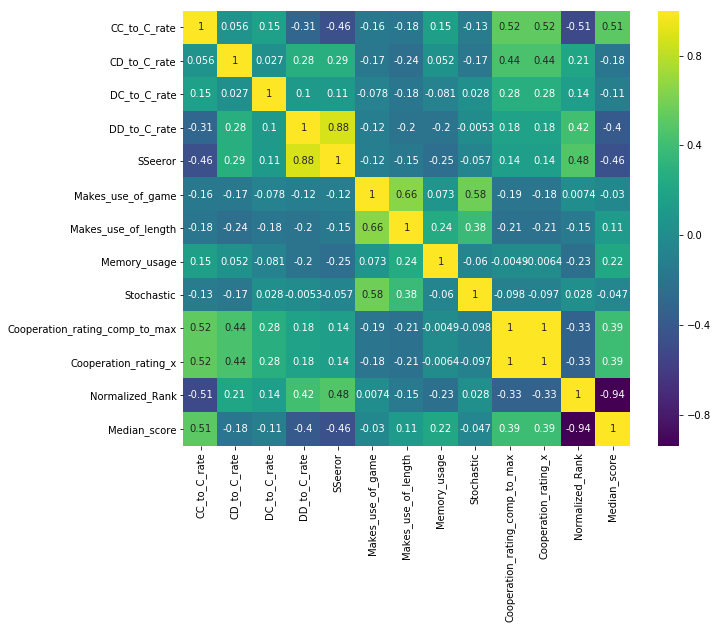

In [19]:
corrmat = corr_data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10, 8))

g = sns.heatmap(corr_data[top_corr_features].corr(), annot=True,cmap="viridis")

In [169]:
X = da.array(ddf[columns].compute(num_workers=4))

In [170]:
y = da.array(ddf[chosen_n_cluster].compute(num_workers=4))

In [111]:
# lr = LogisticRegression(fit_intercept=False).fit(X, y)

In [112]:
with joblib.parallel_backend('dask', n_jobs=num_workers):
    forest = RandomForestClassifier(n_estimators=10,
                                  random_state=0)
    forest.fit(X, y)
    importances = forest.feature_importances_

In [113]:
importances

array([0.11134584, 0.14587451, 0.05745424, 0.08073306, 0.13428659,
       0.00254625, 0.00448041, 0.0199693 , 0.00511072, 0.2682531 ,
       0.16994597])

In [114]:
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

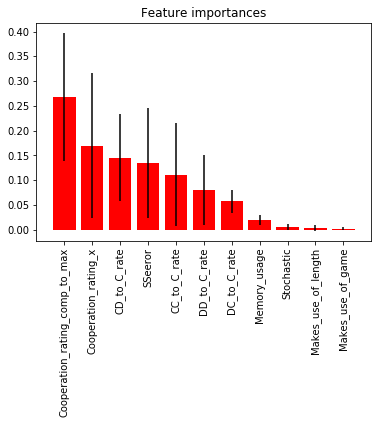

In [115]:
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")

plt.xticks(range(X.shape[1]), [columns[f] for f in indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

In [116]:
from treeinterpreter import treeinterpreter as ti

In [137]:
x = da.array(sample[columns].compute(num_workers=4))

In [138]:
y = da.array(sample[chosen_n_cluster].compute(num_workers=4))

In [119]:
with joblib.parallel_backend('dask', n_jobs=num_workers):
    forest = RandomForestClassifier(n_estimators=10,
                                  random_state=0)
    forest.fit(x, y)

In [120]:
with joblib.parallel_backend('dask', n_jobs=num_workers):
    prediction, bias, contributions = ti.predict(forest, x)

In [121]:
feature_dict = dict((k,[]) for k in list(x))

In [47]:
for instance_contributions in contributions:
    for c, feature in zip(instance_contributions, list(x)):
        feature_dict[feature].append(c)

In [50]:
np.mean(feature_dict['Stochastic'], axis=0)

array([ 0.00079663, -0.00186806,  0.00107143])

In [60]:
for feature in feature_dict.keys():
    feature_dict[feature] = np.mean(feature_dict[feature], axis=0)

In [61]:
for i, feature in enumerate(feature_dict):
    print(feature, feature_dict[feature])

Stochastic [ 0.00079663 -0.00186806  0.00107143]
CC_to_C_rate [-0.00353614  0.00734944 -0.00381329]
Memory_usage [ 0.0030705  -0.00187906 -0.00119144]
Cooperation_rating_x [-0.00528428 -0.00049524  0.00577952]
CD_to_C_rate [ 0.00069152 -0.00725621  0.00656469]
DD_to_C_rate [-0.00461041  0.00176598  0.00284442]
Makes_use_of_length [-0.00175439 -0.00018795  0.00194234]
DC_to_C_rate [-0.0037973  -0.00049113  0.00428843]
SSeeror [ 0.00249409  0.00424437 -0.00673845]
Makes_use_of_game [-1.80451988e-04 -2.86172161e-06  1.83313710e-04]
Cooperation_rating_comp_to_max [ 0.00139594  0.01132072 -0.01271666]


In [90]:
output = """"""

In [91]:
for i, feature in enumerate(feature_dict):
    output += "Feature %s (%s) \n" % (
        feature, 
        (",").join([str(v) for v in feature_dict[feature]]),
    )


In [92]:
output

'Feature Stochastic (0.0007966344432509849,-0.0018680630146795565,0.0010714285714285715) \nFeature CC_to_C_rate (-0.003536144149261934,0.0073494357637118425,-0.00381329161444989) \nFeature Memory_usage (0.003070502961950336,-0.001879058441558441,-0.0011914445203918887) \nFeature Cooperation_rating_x (-0.005284275614427563,-0.0004952394022502835,0.005779515016677853) \nFeature CD_to_C_rate (0.0006915171112583275,-0.007256205403637285,0.006564688292378949) \nFeature DD_to_C_rate (-0.004610406299110459,0.0017659848686328004,0.0028444214304776637) \nFeature Makes_use_of_length (-0.001754388903779145,-0.00018795229161082828,0.001942341195389975) \nFeature DC_to_C_rate (-0.003797299122456848,-0.0004911303838520838,0.004288429506308922) \nFeature SSeeror (0.0024940880983352347,0.004244366419189111,-0.006738454517524342) \nFeature Makes_use_of_game (-0.00018045198848770254,-2.8617216117216977e-06,0.0001833137100994251) \nFeature Cooperation_rating_comp_to_max (0.0013959377484430663,0.011320723

In [48]:
import lime
import lime.lime_tabular

In [49]:
explainer = lime.lime_tabular.LimeTabularExplainer(x.values,
                                                   mode = 'regression',
                                                   feature_names = columns,
)

In [50]:
np.random.seed(42)
exp = explainer.explain_instance(x.values[30], forest.predict)
exp.show_in_notebook(show_all=False)

exp = explainer.explain_instance(x.values[85], forest.predict)
exp.show_in_notebook(show_all=False)

exp.save_to_file('../output/standard/lime.html')

In [51]:
import pydot
from sklearn.tree import export_graphviz

In [52]:
estimator = forest.estimators_[2]

In [53]:
len(forest.estimators_)

10


**Output**

In [1]:
import pydot
from sklearn.tree import export_graphviz

In [59]:
estimator = forest.estimators_[2]

In [64]:
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = columns,
                rounded = True, proportion = False, 
                precision = 10, filled = True)

In [2]:
(graph, ) = pydot.graph_from_dot_file('../output/standard/tree_plots/estimator_0.dot')

In [3]:
graph.write_png('../output/standard/tree_plots/estimator_0.png')

In [68]:
(graph, ) = pydot.graph_from_dot_file('../output/standard/tree_plots/estimator_2.dot')

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:55202 remote=tcp://127.0.0.1:44999>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:55204 remote=tcp://127.0.0.1:44999>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:55206 remote=tcp://127.0.0.1:44999>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:55208 remote=tcp://127.0.0.1:44999>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:55210 remote=tcp://127.0.0.1:44999>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:55212 remote=tcp://127.0.0.1:44999>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:55214 remote=tcp://127.0.0.1:44999>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:55218 remote=tcp://127.0.0.1:44999>
distribu

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting


In [69]:
graph.write_png('../output/standard/tree_plots/estimator_2.png')

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/nightwing/anaconda3/envs/axlml/lib/python3.5/site-packages/distributed/process.py", line 35, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/nightwing/anaconda3/envs/axlml/lib/python

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/nightwing/anaconda3/envs/axlml/lib/python3.5/site-packages/distributed/process.py", line 35, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/nightwing/anaconda3/envs/axlml/lib/python3.5/multiprocessing/process.py", line 113, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/nightwing/anaconda3/envs/axlml/lib/python3.5/site-packages/distributed/process.py", line 35, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/nightwing/anaconda3/envs/axlml/lib/python3.5/multiprocessing/process.py", line 113, in terminate
    self._pop


Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/nightwing/anaconda3/envs/axlml/lib/python3.5/site-packages/distributed/process.py", line 35, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/nightwing/anaconda3/envs/axlml/lib/python3.5/multiprocessing/process.py", line 113, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/nightwing/anaconda3/envs/axlml/lib/python3.5/site-packages/distributed/process.py", line 35, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/nightwing/anaconda3/envs/axlml/li

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/nightwing/anaconda3/envs/axlml/lib/python3.5/site-packages/distributed/process.py", line 35, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/nightwing/anaconda3/envs/axlml/lib/python3.5/multiprocessing/process.py", line 113, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/nightwing/anaconda3/envs/axlml/lib/python3.5/site-packages/distributed/process.py", line 35, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/nightwing/anaconda3/envs/axlml/lib

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.

**Train random forest**

In [166]:
size = len(ddf)
split = int(size * 0.3)

In [167]:
training = X[:-split]
test = X[-split:]

In [171]:
training_Y = y[:-split]
test_Y = y[-split:]

In [172]:
scores = []
for n_estimator in range(5, 15):
    rf = RandomForestClassifier(n_estimators=n_estimator)
    with joblib.parallel_backend('dask', n_jobs=4):
        rf.fit(training, training_Y)
        
        scores.append((rf.score(training, training_Y),
                       rf.score(test, test_Y)))

In [173]:
train_score, test_score = zip(*scores)

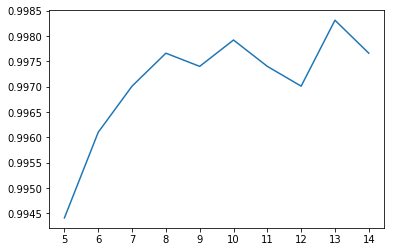

In [174]:
plt.plot(train_score);
plt.xticks(range(0, 10), range(5, 15));

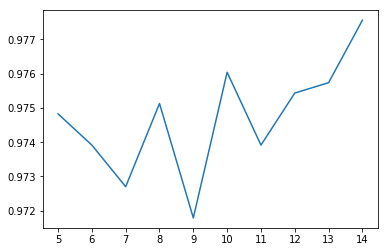

In [175]:
plt.plot(test_score);
plt.xticks(range(0, 10), range(5, 15));